<a href="https://colab.research.google.com/github/lauragabrysiak/mitx_applied_data_science/blob/main/ELECT_06_amazon_prod_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

### **P0: Please read the instructions carefully before starting the project.**

This is a commented Jupyter IPython Notebook file in which all the instructions and tasks to be performed are mentioned. Read along carefully to complete the project.

* Blanks '_______' are provided in the notebook that needs to be filled with an appropriate code to get the correct result. Please replace the blank with the right code snippet. With every '_______' blank, there is a comment that briefly describes what needs to be filled in the blank space.
* Identify the task to be performed correctly, and only then proceed to write the required code.
* Fill the code wherever asked by the commented lines like "# Fill in the blank" or "# Complete the code". Running incomplete code may throw an error.
* Remove the blank and state your observations in detail wherever the mark down says 'Write your observations here:_________'
* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors.
* You can the results/observations derived from the analysis here and use them to create your final report.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
# Installing surprise library
!pip install surprise

# Installing Pandas Profile
!pip install -U ydata-profiling[notebook]==4.0.0 matplotlib==3.5.1

## **P0: Importing the necessary libraries and overview of the dataset**

In [1]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')
from collections import defaultdict             # A dictionary output that does not raise a key error

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # data visualization
import seaborn as sns                           # data visualization advanced

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

from ydata_profiling import ProfileReport       # Adding pandas report
from scipy.stats import pearsonr                # pearson correlation

### **Loading the data**

In [3]:
# Import the dataset
df = pd.read_csv('/content/sample_data/ratings_Electronics.csv', header = None) # There are no headers in the data file

In [4]:
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # backup copy

In [35]:
#### Pandas Report original dataset
# Use df_copy
profile_01 = ProfileReport(df_copy
                        , title="Amazon Recommendation Report"
                        #, subtitle="Original Dataset"
                        )

In [36]:
profile_01.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### **Logical Assumptions: Users with >= 50 ratings**

As this dataset is very large and has 7,824,482 observations (4,201,609 unique users), it is not computationally possible to build a model using this.

Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.

**Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.**

##### USER CUTOFF

In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
len(ratings_count)  # dictionary collecting all users meeting criteria

3028079

In [9]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50
remove_users = []

# using user dictionary for dataset sorting
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)] #filtering users with 50 or more ratings usinf the previously defined dictionary

In [10]:
df.head(4) # filtered set with user having more than 50 ratings each

,user_id,prod_id,rating
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
631,A3TAS1AG6FMBQW,0972683275,5.0


In [29]:
df.shape  # filtered set with user having more than 50 ratings each

(53186, 3)

##### PRODUCT CUTOFF

In [30]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [31]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [32]:
# Print a few rows of the imported dataset
df_final.shape  # filtered set with user having more than 50 ratings each and products having more than 5 ratings each

(19793, 3)

In [19]:
rows, columns = df_final.shape
print(rows, columns)

19793 3


#### **Observations:** The initial dataset was a scarse matrix of

## **P1: Exploratory Data Analysis**

### **Shape of the data**

In [18]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  30886
No of columns:  3


**Write your observations here: The final dataframe has 30886 rows and 3 columns

### **Data types**

In [19]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30886 entries, 6147 to 6177064
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  30886 non-null  object 
 1   prod_id  30886 non-null  object 
 2   rating   30886 non-null  float64
dtypes: float64(1), object(2)
memory usage: 965.2+ KB


**Write your observations here:**

The final dataframe has variables: 2 categorical (object) ones and one numerical (float)

### **Checking for missing values**

In [21]:
# Check for missing values present and provide observations
print(df_final.isnull().sum(),"\n")
print(df_final.isna().sum(),"\n")

user_id    0
prod_id    0
rating     0
dtype: int64 

user_id    0
prod_id    0
rating     0
dtype: int64 



### **Using pandas profile for EDA**

In [22]:
# Using pandas report for EDA
profile = ProfileReport(df_final
                        , title="Amazon Recommendation Report")

In [23]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Write your observations here:**



1.   **Dataframe Structure:** The final dataframe (3 x 30886)  has 3 variables - 2 high cardinality categorical variables (product and user id) and 1 ordinal (rating: [1 -5] ).
2.   **Dataframe Values:** There are no missing values and the dataframe total size in memory is 965.2 KiB.From the pandas report we can see that the 30886 ratings were recorded by 929 unique users which indicates that some users are repetitive (~32 ratings / user).
3.   **Data Insights:** Out of the 30886 ratings there is a total of 3064 unique products indicating ~ 10 ratings x product or a sparse matrix. The next steps will be to perform a multivariate EDA and understand the distributions of the variable values.








### **Summary Statistics**

#### **Checking the rating distribution**

In [25]:
print(df_final.describe(exclude='object').transpose())

          count      mean       std  min  25%  50%  75%  max
rating  30886.0  4.297352  1.012838  1.0  4.0  5.0  5.0  5.0


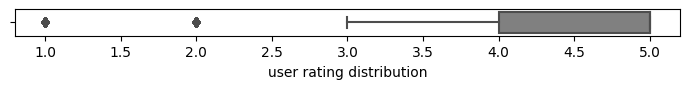

In [155]:
fig = plt.figure(figsize= (7,1))
sns.boxplot(x = df_final["rating"]
            , color = 'grey').set_xlabel("user rating distribution")
fig.tight_layout()

In [58]:
# Summary statistics of 'rating' variable and provide observations
print(df_final["rating"].value_counts(1).describe().transpose())

count    5.000000
mean     0.200000
std      0.226396
min      0.032248
25%      0.040407
50%      0.093732
75%      0.264974
max      0.568640
Name: rating, dtype: float64


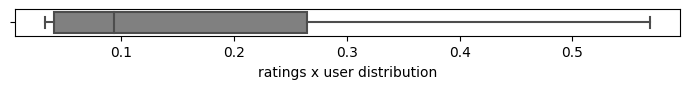

In [156]:
fig = plt.figure(figsize= (7,1))
sns.boxplot(x= df_final["rating"].value_counts(1)
            , color = 'grey').set_xlabel("ratings x user distribution")
fig.tight_layout()

#### **Checking the number of unique users and items in the dataset**

In [61]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', len(df_final['user_id'].unique()))
print('Number of unique ITEMS in Raw data = ', len(df_final['prod_id'].unique()))

The number of observations in the final data =  30886
Number of unique USERS in Raw data =  929
Number of unique ITEMS in Raw data =  3064


**Write your observations here:________**

#### **Users with the most number of ratings**

In [62]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      180
A3OXHLG6DIBRW8    158
A680RUE1FDO8B     141
A1ODOGXEYECQQ8    128
A6FIAB28IS79      126
A17BUUBOU0598B    120
A3LGT6UZL99IW1    118
A2XRMQA6PJ5ZJ8    113
AWPODHOB4GFWL     103
A23GFTVIETX7DS    103
dtype: int64

In [163]:
top_val_prod = df.groupby(['user_id', 'prod_id'])['rating'].agg(['mean', 'count']).reset_index()
top_val_prod.head()

,user_id,prod_id,mean,count
0,A100UD67AHFODS,B00004Z5M1,5.0,1
1,A100UD67AHFODS,B00005T3X7,5.0,1
2,A100UD67AHFODS,B000069EUW,5.0,1
3,A100UD67AHFODS,B000069JWX,1.0,1
4,A100UD67AHFODS,B0000AR0I4,5.0,1


In [164]:
# Top Products
top_prod= df_final.groupby('prod_id')['rating'].agg(['count','mean','median','std']).sort_values(['count'],ascending=False).reset_index()
print(top_prod.head(10).round(),"\n")

      prod_id  count  mean  median  std
0  B0088CJT4U    131   4.0     4.0  1.0
1  B003ES5ZUU    127   5.0     5.0  1.0
2  B000N99BBC    107   5.0     5.0  0.0
3  B002R5AM7C    104   4.0     4.0  1.0
4  B007WTAJTO     99   5.0     5.0  1.0
5  B00829TIEK     93   4.0     5.0  1.0
6  B00829THK0     85   4.0     5.0  1.0
7  B002V88HFE     78   5.0     5.0  1.0
8  B002WE6D44     75   5.0     5.0  1.0
9  B004CLYEDC     75   5.0     5.0  1.0 



In [148]:
# Top users
top_user = df_final.groupby('user_id')['rating'].agg(['count','mean','median','std']).sort_values(['count'],ascending=False).reset_index()
print(top_user.head(10).round(),"\n")

           user_id  count  mean  median  std
0     ADLVFFE4VBT8    180   4.0     5.0  1.0
1   A3OXHLG6DIBRW8    158   4.0     5.0  1.0
2    A680RUE1FDO8B    141   5.0     5.0  1.0
3   A1ODOGXEYECQQ8    128   4.0     4.0  1.0
4     A6FIAB28IS79    126   4.0     5.0  1.0
5   A17BUUBOU0598B    120   3.0     4.0  1.0
6   A3LGT6UZL99IW1    118   4.0     4.0  1.0
7   A2XRMQA6PJ5ZJ8    113   5.0     5.0  1.0
8    AWPODHOB4GFWL    103   4.0     5.0  1.0
9   A23GFTVIETX7DS    103   4.0     5.0  1.0
10  A36K2N527TXXJN    103   5.0     5.0  1.0
11  A2UOHALGF2X77Q    102   4.0     5.0  1.0
12  A2WLNSZ9U0T1S3    102   4.0     5.0  1.0
13   AGVWTYW0ULXHT    102   4.0     4.0  1.0
14  A3EXWV8FNSSFL6     95   4.0     5.0  1.0 



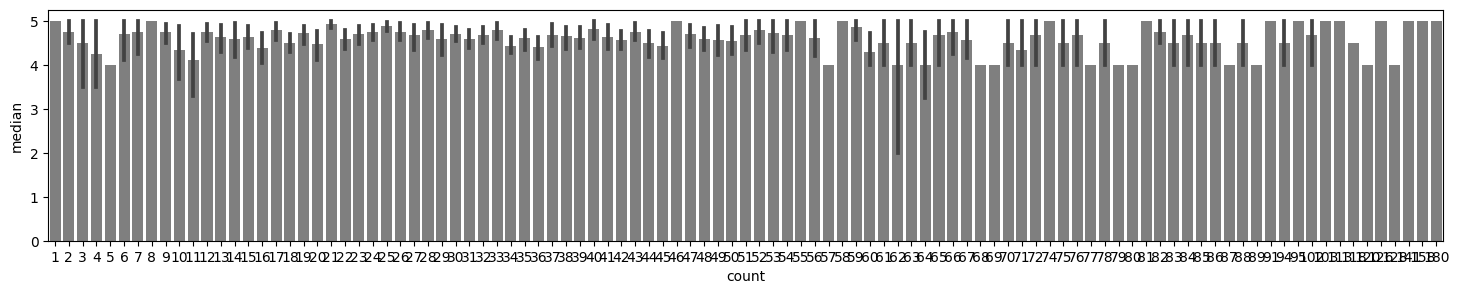

In [157]:
plt.figure(figsize=(18, 3))
sns.barplot(x='count'
            #, y='mean'
            , y='median'
            , data=top_user
            , color="black"
            , alpha = 0.5
            )
fig.tight_layout()
plt.show()

            user_id      mean  median  count
0    A100UD67AHFODS  4.718750     5.0     32
1    A100WO06OQR8BQ  3.900000     5.0     50
2    A105TOJ6LTVMBG  4.071429     5.0     28
3    A10NMELR4KX0J6  4.125000     5.0     24
4    A10O7THJ2O20AG  5.000000     5.0     33
..              ...       ...     ...    ...
924   AZ515FFZ7I2P7  3.892857     4.0     56
925   AZ8XSDMIX04VJ  5.000000     5.0     21
926   AZAC8O310IK4E  4.423729     5.0     59
927   AZMY6E8B52L2T  4.560976     5.0     41
928   AZNUHQSHZHSUE  4.458333     5.0     24

[929 rows x 4 columns] 

Conclusion: correlation of -0.0108 with p-value of: 0.7416 H0 cannot be rejected i.e., no significant correlation between rating/user and rating value 



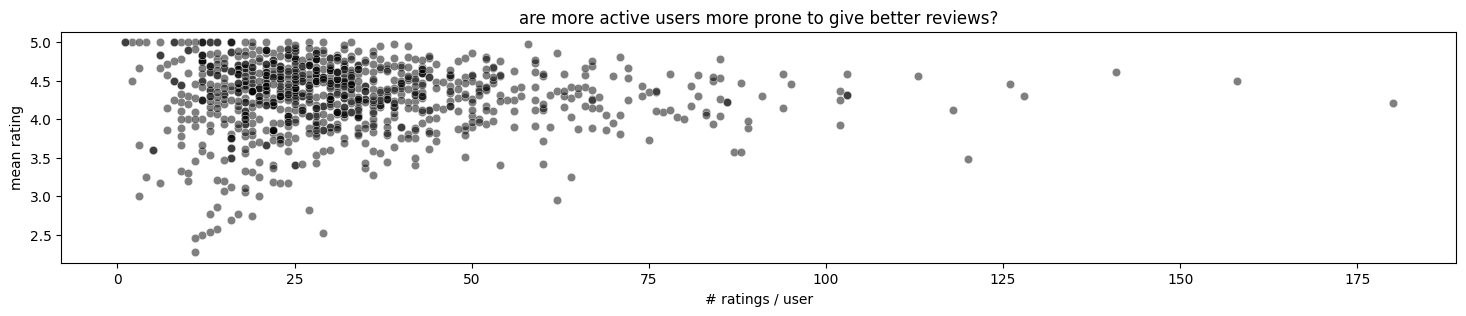

In [179]:
# are more active users more prone to give better reviews?
user_ratings = df_final.groupby('user_id')['rating'].agg(['mean', 'median', 'count']).reset_index()
print(user_ratings, "\n")

# is there a correlation between # ratings / user and man rating?
# using Pearson correlation significance test for context:
# H0: no correlation in the population (correlation equals zero) whereas H1 is that there is a correlation.
# p-value <= 0.05 suggests that you can reject H0, indicating that there is evidence of a significant correlation.

corr, p_value = pearsonr(user_ratings['count']
                         , user_ratings['mean'])
print("Conclusion: correlation of",round(corr,4),"with p-value of:", round(p_value,4), "H0 cannot be rejected i.e., no significant correlation between rating/user and rating value", "\n")

# show relationship with scatterplot
plt.figure(figsize=(18, 3))
sns.scatterplot(x='count'
                , y='mean'
                , data=user_ratings
                , color = 'black'
                , alpha=0.5)
plt.title('are more active users more prone to give better reviews?')

plt.xlabel('# ratings / user')
plt.ylabel('mean rating')

fig.tight_layout()
plt.show()

   value   freq  freq_%
0    5.0  17563    0.57
1    4.0   8184    0.26
2    3.0   2895    0.09
3    2.0   1248    0.04
4    1.0    996    0.03 



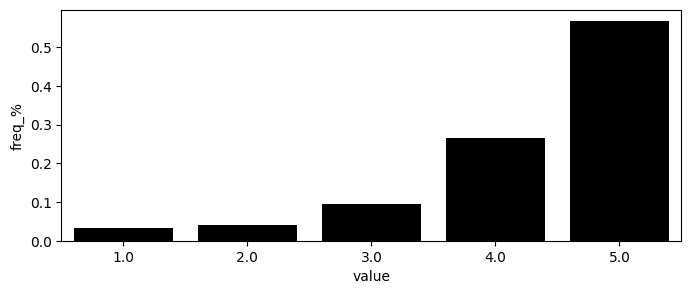

In [183]:
# look at distribution of rating values
top_val = df_final['rating'].value_counts().reset_index()
top_val.columns = ['value', 'freq']
top_val["freq_%"] = top_val['freq'] / top_val['freq'].sum()

print(round(top_val,2).sort_values(by='value', ascending=False), "\n")

plt.figure(figsize=(8, 3))
sns.barplot(x='value'
            , y='freq_%'
            , data=top_val
            , color="black"
            )
fig.tight_layout()
plt.show()

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

**EDA Conclusions**


1.   Class imbalance: 57% 5*, 26% 4*, 0.9% 3*, 0.4% 2* and 0.3% 1
2.   Rating distributions:
3.   User distributions:
4.   User x Rating insights:

## **Model 1: Rank Based Recommendation System**

In [160]:
# Recap of our final dataframe:
df_final.head(10)

,user_id,prod_id,rating
6147,A1C82BC5GNABOA,9983891212,5.0
6208,A1VHCO8RQFIGQJ,9983891212,4.0
6244,A3L6L5O89JTX2T,9983891212,5.0
6253,A1OGCPMSIVK7G4,9983891212,5.0
6268,A18HE80910BTZI,9983891212,5.0
6301,A3F9CBHV4OHFBS,9983891212,5.0
11153,A105TOJ6LTVMBG,B00000J1V5,4.0
11182,A14JBDSWKPKTZA,B00000J1V5,5.0
11205,A13WREJ05GMRA6,B00000J1V5,3.0
11383,A3J8A5L5AF5TX9,B00000J1V5,5.0


### Steps:

- **Create the final_rating DataFrame**
- **Complete the code to create the function top_n_products**
- **Recommending top 5 products with 50 minimum interactions based on popularity**
- **Recommending top 5 products with 100 minimum interactions based on popularity**

In [38]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean().reset_index()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count().reset_index()

# Create a dataframe with calculated average and count of ratings
#final_rating = pd.DataFrame()
final_rating  = df_final.groupby('prod_id')['rating'].agg(['mean','count']).reset_index()

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(['count'], ascending = False).reset_index()

# See the first five records of the "final_rating" dataset
final_rating.head()

,index,prod_id,mean,count
0,1424,B003ES5ZUU,4.840000,100
1,1240,B002R5AM7C,4.147727,88
2,476,B000N99BBC,4.756098,82
3,1717,B004CLYEDC,4.650794,63
4,1255,B002SQK2F2,2.982456,57


In [41]:
print(avg_rating.head(), "\n\n"
      , count_rating.head(), "\n\n"
      , final_rating.head(), "\n\n"
      )

      prod_id    rating
0  B00000K4KH  5.000000
1  B00001P4XA  3.888889
2  B00001P4ZH  4.375000
3  B00001W0DI  4.800000
4  B00001WRSJ  4.222222 

       prod_id  rating
0  B00000K4KH       5
1  B00001P4XA       9
2  B00001P4ZH       8
3  B00001W0DI       5
4  B00001WRSJ       9 

    index     prod_id      mean  count
0   1424  B003ES5ZUU  4.840000    100
1   1240  B002R5AM7C  4.147727     88
2    476  B000N99BBC  4.756098     82
3   1717  B004CLYEDC  4.650794     63
4   1255  B002SQK2F2  2.982456     57 




In [43]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

# p1: final_rating: dataframe to sort
# p2: n: n products
# p3: min_interactions: def what a min interaction is (min())

def top_n_products(final_rating, n, min_interaction_def):

    # Finding products with minimum number of interactions
    #min_interaction_def = final_rating['count'].min()                                     # def a min interaction
    min_recommendations = final_rating[final_rating['count'] >=  min_interaction_def]      # recommendations that comprise def of min interactions had to be fixed to be >= as they are min requirements

    # Sorting values with respect to average rating
    sorted_recommendations = min_recommendations.sort_values(['mean'], ascending = False).reset_index()

    return sorted_recommendations[:n]
    #return sorted_recommendations.index[:n]  # returning n rows ---> template code was shared with an error
    # Obs: Function is not working correctly showing the df.index()

In [44]:
# Testing top 50 prod with 5 min_interactions)
result = top_n_products(final_rating, 10, 50)

test = final_rating[final_rating['count'] ==  50].sort_values(['mean'], ascending = False)
# test = final_rating[final_rating['count'] ==  final_rating['count'].min()].sort_values(['mean'], ascending = False)

print(
      final_rating.head()
      , "\n\n"
      , result # getting the index
      , "\n\n"
      , test[:10]
      )

   index     prod_id      mean  count
0   1424  B003ES5ZUU  4.840000    100
1   1240  B002R5AM7C  4.147727     88
2    476  B000N99BBC  4.756098     82
3   1717  B004CLYEDC  4.650794     63
4   1255  B002SQK2F2  2.982456     57 

    level_0  index     prod_id      mean  count
0        0   1424  B003ES5ZUU  4.840000    100
1        7   1305  B002WE6D44  4.800000     55
2        8   1719  B004CLYEFK  4.784314     51
3        2    476  B000N99BBC  4.756098     82
4        5   1280  B002V88HFE  4.750000     56
5       10   1341  B0034CL2ZI  4.720000     50
6        3   1717  B004CLYEDC  4.650794     63
7        9    444  B000JMJWV2  4.607843     51
8       11   1628  B0041Q38NU  4.480000     50
9        1   1240  B002R5AM7C  4.147727     88 

     index     prod_id  mean  count
10   1341  B0034CL2ZI  4.72     50
11   1628  B0041Q38NU  4.48     50


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [45]:
top_n_products(final_rating, 5, 50)

,level_0,index,prod_id,mean,count
0,0,1424,B003ES5ZUU,4.840000,100
1,7,1305,B002WE6D44,4.800000,55
2,8,1719,B004CLYEFK,4.784314,51
3,2,476,B000N99BBC,4.756098,82
4,5,1280,B002V88HFE,4.750000,56


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [46]:
top_n_products(final_rating, 5, 100)

,level_0,index,prod_id,mean,count
0,0,1424,B003ES5ZUU,4.84,100


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example, buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [47]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [50]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [51]:
print(final_rating.info()
      , "\n\n"
      , final_rating.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    2143 non-null   int64  
 1   prod_id  2143 non-null   object 
 2   mean     2143 non-null   float64
 3   count    2143 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 67.1+ KB
None 

    index     prod_id      mean  count
0   1424  B003ES5ZUU  4.840000    100
1   1240  B002R5AM7C  4.147727     88
2    476  B000N99BBC  4.756098     82
3   1717  B004CLYEDC  4.650794     63
4   1255  B002SQK2F2  2.982456     57


In [52]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets (80/20)
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

In [53]:
print(reader, "\n\n"
      , data, "\n\n"
      , trainset, "\n\n"
      , testset[:2]
      )




 [('A1NNMOD9H36Q8E', 'B00009MDBQ', 5.0), ('A15QYHQH80W30L', 'B000HZBR64', 5.0)]


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

- **Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1**

- **Fit the model on the training data**

- **Use the precision_recall_at_k function to calculate the metrics on the test data**

- **Provide your observations on the output**

In [54]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options provided, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options
                         , verbose=False
                         , random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

In [55]:
precision_recall_at_k(sim_user_user)

RMSE: 1.0638
Precision:  0.841
Recall:  0.884
F_1 score:  0.862


In [56]:
predictions = sim_user_user.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 1.0638
RMSE: 1.0638381321780395


**Write your observations here:__________**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5 which is denoted by the parameter r_ui.

In [57]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.299797903246179, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**

Here's the rewritten text to be more direct and concise:
- User ID (uid): A3LDPF5FMB782Z
- Item ID (iid): 1400501466
- Actual Rating (r_ui): 5.00
- Estimated Rating (est): 4.30
- Details: {'was_impossible': True, 'reason': 'User and/or item is unknown.'}

The given information shows that the recommendation system could not make a prediction for the user with ID A3LDPF5FMB782Z and item with ID 1400501466. This is because either the user or the item is unknown to the system. To improve the system's accuracy for this user and item, more data or additional features are needed.

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [58]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [59]:
n_users_not_interacted_with(5, df_final, '1400501466')

['A105TOJ6LTVMBG',
 'A2NVQZ4Y7Y0J1R',
 'A3DOPYDOS49I3T',
 'A2JP9E1H0SF392',
 'A1EXGL6L0QQ0M5']

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [60]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A2UOHALGF2X77Q", "1400501466", verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.299797903246179, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**

Let's analyze the information provided for this prediction:

*   User ID (uid): A2UOHALGF2X77Q
*   Item ID (iid): 1400501466
*   Actual Rating (r_ui): None (There is no specified actual rating for this user-item interaction)
*   Estimated Rating (est): 4.30 (The predicted or estimated rating for the item by the recommendation system)
*   Details: {'was_impossible': True, 'reason': 'User and/or item is unknown.'} (Additional details about the prediction, indicating that the user or item is unknown)

**Interpretation:**
The system couldn't provide an actual rating for the user-item interaction due to insufficient information about the user or the item. To improve accuracy, comprehensive data is vital in the training set that covers a diverse range of users and items. If this user or item is crucial, collect more data or explore techniques to handle missing information.

### **Improving Similarity-based Recommendation System by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [64]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
        'k':[40],                      # number of neighbors to consider
        'min_k': [1],                   # minimum number of neighbors to take into account for aggregation
        'sim_options': {
        'name': ['cosine'
                , 'pearson'
                , 'msd']  # similarity metric (cosine or pearson)
}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic
                  , param_grid
                  , measures = ['rmse']
                  , cv = 3
                  , n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(" Best RMSE score", gs.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs.best_params['rmse'], "\n")

 Best RMSE score 1.054090843553987 


Combination of parameters for best RMSE score {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}} 



Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

*Combination of parameters for best RMSE score {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}}*

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [66]:
# Using the optimal similarity measure for user-user based collaborative filtering
# us ethe previous hyperparameters

sim_options = {'name': 'pearson'
              , 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options
                                   , k=gs.best_params['rmse']['k']
                                   , min_k=1
                                   , random_state=1
                                   , verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0473
Precision:  0.83
Recall:  0.916
F_1 score:  0.871


**Write your observations here:**

**Comparison of both models:**

| Metric Description                                                                                    | Metric    | Optimized | Original | Diff     |
| ----------------------------------------------------------------------------------------------------- | --------- | --------- | -------- | -------- |
| Root Mean Squared Error                                                                               | RMSE      | 1.0473    | 1.0638   | \-0.0165 |
| Precision is the ratio of correctly predicted positive observations to the total predicted positives. | Precision | 0.83      | 0.841    | \-0.011  |
| Recall is the ratio of correctly predicted positive observations to all actual positives.             | Recall    | 0.916     | 0.884    | 0.032    |
| F1 score is the harmonic mean of precision and recall. It balances both metrics.                      | F_1       | 0.871     | 0.862    | 0.009    |


An increase in precision and recall is generally a positive sign, especially if F1 score also increases. An increase in F1 score by 0.09 suggests an improvement in the trade-off between precision and recall.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [67]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466

# original model
# sim_user_user.predict("A2UOHALGF2X77Q", "1400501466", verbose = True)

# optimized model
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.299797903246179, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [68]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"

# original model
# sim_user_user.predict("A2UOHALGF2X77Q", "1400501466", verbose = True)

# optimized model
sim_user_user_optimized.predict("A2UOHALGF2X77Q", "1400501466", verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.299797903246179, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**

There seems to be an issue with the dataset as these users are not being odentified.

### **Identifying similar Users to a given User (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [69]:
# 0 is the inner id of the user
sim_user_user_optimized.get_neighbors(0, 5)

[105, 291, 333, 381, 418]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [70]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [71]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [72]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B0009H5VVM,5
1,B000OG6I6A,5
2,B0018BTPLK,5
3,B001NJ0D0Y,5
4,B002MAPRYU,5


**Write your observations here:**____________

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = _________, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(___________)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(___________)

**Write your observations here:**____________

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`**. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.____________

**Write your observations here:**____________

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item._____________

**Write your observations here:**____________

### **Hyperparameter tuning the item-item similarity-based model**

- Use the following values for the param_grid and tune the model
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {_____________}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(____________)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.____________)

# Find the combination of parameters that gave the best RMSE score
print(gs.____________)

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {______________}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(_________ , _________ , ___________ , random_state = 1, verbose = False)

# Training the algorithm on the train set
______________

# Let us compute precision@k and recall@k, f1_score and RMSE
_________________

**Write your observations here:__________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
_________________

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
__________________

**Write your observations here:__________**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized._____________

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

**Write your observations here:__________**

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = ___________

# Training the algorithm on the train set
svd._____________

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
_____________

**Write your observations here:___________**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

**Write your observations here:___________**

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A2UOHALGF2X77Q", "1400501466", verbose = True)

**Write your observations here:___________**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(_______, _________, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.___________)

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(________________)

# Train the algorithm on the train set
_______________

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
______________

**Write your observations here:_____________**

**Let's now predict a rating for a user with `userId = "A3LDPF5FMB782Z"` and `productId = "1400501466"` with the optimized model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
_________________

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
__________________

**Write your observations here:**_____________

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**